# MNIST 

## basic code (keras 사용 X)

In [1]:
import tensorflow as tf
import numpy as np
a = tf.keras.datasets.mnist.load_data()
print(type(a))

<class 'tuple'>


In [2]:
#mnist data를 좀 더 파헤쳐보자
for i in a :
    print(type(i))

<class 'tuple'>
<class 'tuple'>


tuple 2개로 되어있으니까 조금 더 나눠서 살펴보자

In [3]:
#data set을 unpacking 해서 받기
a, b = tf.keras.datasets.mnist.load_data()

In [4]:
for i in a :
    print(type(i))
for i in b :
    print(type(i))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


2개의 tuple 각각이 numpy array 2개로 이루어져 있다.

In [5]:
#data set을 좀 더 나눠서 받기
(a, b), (c, d) = tf.keras.datasets.mnist.load_data()

In [6]:
x_train = a
y_train = b

x_test = c
y_test = d

In [7]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


train set은 60000장씩, test set은 10000장씩 있다.

train set 각각은 28*28

In [8]:
print(x_train.max(), y_train.max(), x_test.max(), y_test.max())
print(x_train.min(), y_train.min(), x_test.min(), y_test.min())

255 9 255 9
0 0 0 0


In [9]:
#x를 reshape(0하고 1사이 숫자로 만들고 싶어!).
x_train = a.reshape( (-1, 784) ).astype(np.float32) / 255  
x_test = c.reshape( (-1, 784) ).astype(np.float32) / 255

#y도 엄밀하게 다시 정의해주자.
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

<function matplotlib.pyplot.show(*args, **kw)>

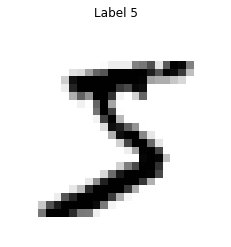

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(x_train[0].reshape((28, 28)), cmap = plt.cm.binary)
plt.axis('off')
plt.title('Label {}'.format(y_train[0]))
plt.show

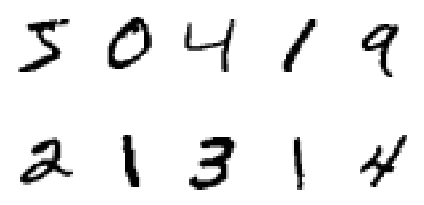

In [11]:
fig, axes = plt.subplots(2, 5) #axes object가 numpy. 
#shape을 보면 (1, 10)이 아닌 (10,)이 나온다. 반대일 경우에도 동일.
#but 1이 아니라 다른 숫자가 들어가면 그대로 나온다.

# 그림 그리기
for i in range(2) :
    for j in range(5) :
        idx = i*5 + j
        img = x_train[idx].reshape((28, 28))
        lbl = y_train[idx]
        axes[i, j].imshow(img, cmap=plt.cm.binary)
        axes.ravel()[idx].set_axis_off()
plt.tight_layout()
plt.show()

In [12]:
epochs = 5
batch_size = 128
lr = 1e-3

In [13]:
tf.reset_default_graph()

In [14]:
#################여기부터

x = tf.placeholder(tf.float32, (None,784)) 
y = tf.placeholder(tf.int32, (None,)) 

init_b = tf.keras.initializers.constant(0.0)
init_w = tf.keras.initializers.VarianceScaling(mode='fan_avg')

#graph의 가장 핵심되는 부분!
b1 = tf.get_variable('b1', (512,), tf.float32, init_b)
w1 = tf.get_variable('w1', (784,512), tf.float32, init_w)

b2 = tf.get_variable('b2', (10,), tf.float32, init_b)
w2 = tf.get_variable('w2', (512,10), tf.float32, init_w)

x1 = tf.nn.relu(x @ w1 + b1) 
logits = x1 @ w2 + b2 

entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits) 
loss = tf.reduce_mean(entropy) 
train = tf.train.RMSPropOptimizer(lr).minimize(loss)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [15]:
print(entropy)

Tensor("SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:0", shape=(?,), dtype=float32)


In [16]:
#prediction이 어떻게 될 것인가.
y_pred = tf.cast(tf.argmax(logits, axis=1), tf.int32, name='y_pred_cls') 

######여기까지가 main graph. 대부분 여기까지에서 shape 때문에 error가 난다.

print(tf.argmax(logits, axis =1))

Tensor("ArgMax_1:0", shape=(?,), dtype=int64)


in64여서 위 코드에서 int32로 바꿔줌!

In [17]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

###########################여기까지가 graph 전부라고 생각하면 됨.

In [18]:
def shuffle_batch(x, y, batch_size):
    rnd_idx = np.random.permutation(len(x))
    n_batches = len(x) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches): #60000장을 128개씩 나눠서 하는데 예쁘게 안 떨어져서 쓰는 코드...
        yield x[batch_idx], y[batch_idx]

In [19]:
#np.array_split : 최대한 균등하게 나눠주는 것
for i in np.array_split(np.arange(10), 4) :
    print(i)

[0 1 2]
[3 4 5]
[6 7]
[8 9]


In [20]:
with tf.Session() as sess:
    sess.run(init)
    #saver.restore(sess, 'save/nn.ckpt')
    
    loss_trace = []
    accuracy_trace = []

    for i in range(epochs):
        print()
        print('epoch {}/{}'.format(i, epochs), end=' ')
        for x_batch, y_batch in shuffle_batch(x_train, y_train, batch_size):
            feed_dict = {x: x_batch, y: y_batch}
            loss_run, accuracy_run, _ = sess.run([loss, accuracy, train], feed_dict=feed_dict)
            loss_trace.append(loss_run)
            accuracy_trace.append(accuracy_run)

    feed_dict = {x: x_test, y: y_test}
    accuracy_run, y_test_pred = sess.run([accuracy, y_pred], feed_dict=feed_dict)


epoch 0/5 
epoch 1/5 
epoch 2/5 
epoch 3/5 
epoch 4/5 

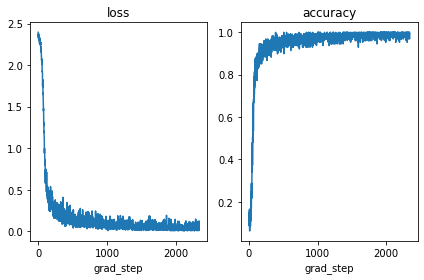

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(loss_trace)
ax2.plot(accuracy_trace)
ax1.set_title('loss')
ax2.set_title('accuracy')
ax1.set_xlabel('grad_step')
ax2.set_xlabel('grad_step')
plt.tight_layout()
plt.show()

In [22]:
print('Test Accuracy :', accuracy_run)

Test Accuracy : 0.9808


In [23]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
print(cm)

[[ 970    1    0    1    0    2    3    1    1    1]
 [   0 1128    2    0    0    1    2    0    2    0]
 [   4    4 1005    2    1    0    2   10    4    0]
 [   0    0    8  992    0    1    0    7    1    1]
 [   1    0    2    0  961    0    3    3    0   12]
 [   2    0    0    6    1  877    4    0    1    1]
 [   5    3    0    1    4    3  941    0    1    0]
 [   1    3    6    1    0    0    0 1014    1    2]
 [   2    0    4    7    4    6    1    8  937    5]
 [   3    3    0    5    6    1    0    7    1  983]]


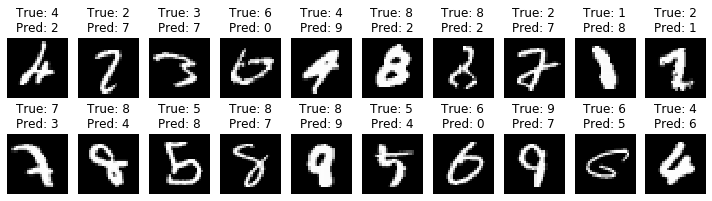

In [24]:
#틀린 것들 살펴보자
fig, axes = plt.subplots(2, 10, figsize=(10,3))
idx = 0

#reshape 중요!!!
for ax in axes.reshape((-1,)):
    while True:
        if y_test[idx]==y_test_pred[idx]:
            idx += 1
        else:
            ax.imshow(x_test[idx].reshape((28,28)), cmap=plt.cm.gray)
            ax.set_title('True: {}\nPred: {}'.format(y_test[idx], y_test_pred[idx])) 
            ax.axis('off')
            idx += 1
            break
plt.tight_layout()
plt.show()

## keras code 사용

In [25]:
from keras.utils import to_categorical
y_train_labels = to_categorical(y_train) #one_hot_encoding이 되어있나 봄.
y_test_labels = to_categorical(y_test)

Using TensorFlow backend.


In [26]:
tf.reset_default_graph()

In [27]:
from keras import models
from keras import layers

###이 부분에서 error 많이 발생
nn = models.Sequential()
nn.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
nn.add(layers.Dense(10, activation='softmax'))
########################
#basic code에 비해 짧고 간단하다!

#training part. 여기는 basic이 더 낫대
#compile!
nn.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [28]:
nn.fit(x_train, y_train_labels, epochs=epochs, batch_size=batch_size) #default lr 사용
#lr을 바꾸려면 어떻게 해야할까???


Epoch 1/5
60000/60000 [==============================] - 4s 65us/step - loss: 0.2582 - accuracy: 0.9241
Epoch 2/5
60000/60000 [==============================] - 4s 64us/step - loss: 0.1034 - accuracy: 0.9701
Epoch 3/5
60000/60000 [==============================] - 4s 63us/step - loss: 0.0699 - accuracy: 0.9783
Epoch 4/5
60000/60000 [==============================] - 4s 70us/step - loss: 0.0505 - accuracy: 0.9846
Epoch 5/5
60000/60000 [==============================] - 4s 65us/step - loss: 0.0382 - accuracy: 0.9886


In [29]:
test_loss, test_acc = nn.evaluate(x_test, y_test_labels)
print('test_acc:', test_acc)

10000/10000 [==============================] - 0s 40us/step
test_acc: 0.9787999987602234


In [30]:
nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


## mix code

In [31]:
tf.reset_default_graph()

In [32]:
##### keras code
from keras import models
from keras import layers
nn = models.Sequential()
nn.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
nn.add(layers.Dense(10, activation=None)) #굳이 softmax 할 필요 없어서 None으로 해 놓음.

x = nn.input
logits = nn.output

###### basic code
y_pred = tf.cast(tf.argmax(logits, axis=1), tf.int32, name='y_pred_cls') 

y = tf.placeholder(tf.int32, (None,)) 
entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits) 
loss = tf.reduce_mean(entropy) 
train = tf.train.RMSPropOptimizer(lr).minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [34]:
with tf.Session() as sess:
    init.run()
    
    loss_trace = []
    accuracy_trace = []

    for i in range(epochs):
        print()
        print('epoch {}/{}'.format(i, epochs), end=' ')
        for x_batch, y_batch in shuffle_batch(x_train, y_train, batch_size):
            feed_dict = {x: x_batch, y: y_batch}
            loss_run, accuracy_run, _ = sess.run([loss, accuracy, train], feed_dict=feed_dict)
            loss_trace.append(loss_run)
            accuracy_trace.append(accuracy_run)

    feed_dict = {x: x_test, y: y_test}
    accuracy_run, y_test_pred = sess.run([accuracy, y_pred], feed_dict=feed_dict)


epoch 0/5 
epoch 1/5 
epoch 2/5 
epoch 3/5 
epoch 4/5 

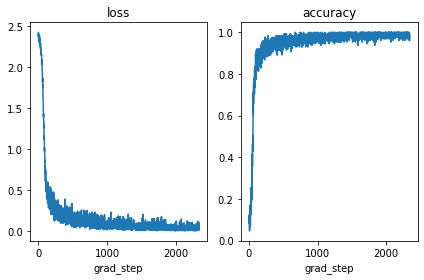

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(loss_trace)
ax2.plot(accuracy_trace)
ax1.set_title('loss')
ax2.set_title('accuracy')
ax1.set_xlabel('grad_step')
ax2.set_xlabel('grad_step')
plt.tight_layout()
plt.show()

### kernel이랑 bias는 어떻게 initialize 되었을까?

아마도 kernel은 random uniform으로... bias는 0으로 보통 initialize한다고 함.

initializer를 바꾸고 싶으면 어떻게 해야할까?

In [36]:
g = tf.get_default_graph()

In [39]:
for op in g.get_operations() :
    for tensor in op.outputs :
        print(tensor.name)

dense_1_input:0
dense_1/random_uniform/shape:0
dense_1/random_uniform/min:0
dense_1/random_uniform/max:0
dense_1/random_uniform/RandomUniform:0
dense_1/random_uniform/sub:0
dense_1/random_uniform/mul:0
dense_1/random_uniform:0
dense_1/kernel:0
dense_1/kernel/IsInitialized/VarIsInitializedOp:0
dense_1/kernel/Read/ReadVariableOp:0
dense_1/Const:0
dense_1/bias:0
dense_1/bias/IsInitialized/VarIsInitializedOp:0
dense_1/bias/Read/ReadVariableOp:0
dense_1/MatMul/ReadVariableOp:0
dense_1/MatMul:0
dense_1/BiasAdd/ReadVariableOp:0
dense_1/BiasAdd:0
dense_1/Relu:0
dense_2/random_uniform/shape:0
dense_2/random_uniform/min:0
dense_2/random_uniform/max:0
dense_2/random_uniform/RandomUniform:0
dense_2/random_uniform/sub:0
dense_2/random_uniform/mul:0
dense_2/random_uniform:0
dense_2/kernel:0
dense_2/kernel/IsInitialized/VarIsInitializedOp:0
dense_2/kernel/Read/ReadVariableOp:0
dense_2/Const:0
dense_2/bias:0
dense_2/bias/IsInitialized/VarIsInitializedOp:0
dense_2/bias/Read/ReadVariableOp:0
dense_2/Mat

# MLE
## Capture-Recapture Method

In [40]:
%matplotlib inline

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as ss

    
def capture_recapture(c, r, t):
    # n - Number of blue jeys in the forest, unknown
    # c - Number of blue jeys captured, tagged, and release
    # r - Number of blue jeys re-captured 
    # t - Number of blue jeys tagged in re-captured stage
    
    prob = []
    for n in range((c+r-t), 10*(c+r-t) + 1):
        prob_temp = ss.comb(c,t) * ss.comb(n-c,r-t) / ss.comb(n,r) 
        prob.append(prob_temp)

    # mle
    ind = prob.index(max(prob))
    n_mle = ind+(c+r-t)
    print('Number of blue jeys in the forest: {}'.format(n_mle))

    plt.plot(range((c+r-t), 10*(c+r-t) + 1), prob)
    plt.scatter(n_mle, prob[ind], color='red')
    plt.show()

Number of blue jeys in the forest: 49


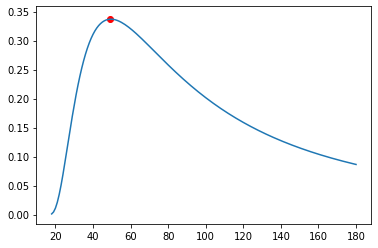

In [43]:
if __name__ == '__main__':
           # n - Number of blue jeys in the forest, unknown
    c = 10 # c - Number of blue jeys captured, tagged, and release
    r = 10 # r - Number of blue jeys re-captured 
    t = 2  # t - Number of blue jeys tagged in re-captured stage
    
    capture_recapture(c, r, t)